### Generalised functions for final report

use 2-3 functions in one place so that further obtain all the results at one place
        

In [1]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import gc
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

import gc
from sklearn.preprocessing import MinMaxScaler
import os
np.random.seed(123)

_FOLDER = "../drug_results/"

In [2]:
def read_hyperparameters(coefficient, folder_name= _FOLDER):
    hyperparameters = pd.read_csv(folder_name+"best_model_coef_"+str(coefficient)+".csv").drop(["Unnamed: 0"], axis=1)
    hyperparameters.set_index("DRUG_ID", inplace = True)
    return hyperparameters

def read_possible_features(folder_name = _FOLDER):
    
    #columns to normalise:
    with open(folder_name+"columns_to_normalise.txt", 'r') as f:
        columns_to_normalise = [line.rstrip('\n') for line in f]
    # *****************************************

    with open(folder_name+"X_features_cancer_cell_lines.txt", 'r') as f:
        X_cancer_cell_lines = [line.rstrip('\n') for line in f]
    # *****************************************

    with open(folder_name+"X_PubChem_properties.txt", 'r') as f:
        X_PubChem_properties = [line.rstrip('\n') for line in f]
    # *****************************************

    with open(folder_name+"X_features_Targets.txt", 'r') as f:
        X_targets = [line.rstrip('\n') for line in f]
    # *****************************************

    with open(folder_name+"X_features_Target_Pathway.txt", 'r') as f:
        X_target_pathway = [line.rstrip('\n') for line in f]
        
    return X_cancer_cell_lines, X_PubChem_properties, X_targets, X_target_pathway

def X_feature_dataset(data_set, folder_name= _FOLDER):
    
    X_cancer_cell_lines, X_PubChem_properties, X_targets, X_target_pathway = read_possible_features(folder_name)
    X_feat_dict = {"Dataset 1": X_cancer_cell_lines ,
               "Dataset 2": ["MAX_CONC"] + X_targets + X_target_pathway + X_cancer_cell_lines ,
               "Dataset 3": ["MAX_CONC"] + X_PubChem_properties +  X_cancer_cell_lines,
               "Dataset 4": ["MAX_CONC"] + X_PubChem_properties +  X_targets + X_target_pathway + X_cancer_cell_lines}

    return X_feat_dict[data_set]


def set_kernel_model_drug_id(model, hyperparameters_df, drug_id):
    
    kernel_type = model.split("_")[0].lower()
    model_type = model.split("_")[1]
    
    if model_type == "KR":
        if (kernel_type == "polynomial") | (kernel_type == "poly"):
            model = KernelRidge(kernel = "polynomial", 
                        alpha = hyperparameters_df.loc[drug_id, "best_alpha3"], 
                        gamma = hyperparameters_df.loc[drug_id, "best_gamma3"],
                        coef0= hyperparameters_df.loc[drug_id, "best_coef03"], 
                        degree = hyperparameters_df.loc[drug_id, "best_degree3"])
        elif kernel_type == "rbf":
            model = KernelRidge(kernel = "rbf", 
                        alpha = hyperparameters_df.loc[drug_id, "best_alpha3"], 
                        gamma = hyperparameters_df.loc[drug_id, "best_gamma3"],
                        coef0= hyperparameters_df.loc[drug_id, "best_coef03"])
        elif kernel_type == "sigmoid":
            model = KernelRidge(kernel = "sigmoid", 
                        alpha = hyperparameters_df.loc[drug_id, "best_alpha3"], 
                        gamma = hyperparameters_df.loc[drug_id, "best_gamma3"],
                        coef0= hyperparameters_df.loc[drug_id, "best_coef03"])
        elif kernel_type == "linear":
            model = KernelRidge(kernel = "linear", 
                        alpha = hyperparameters_df.loc[drug_id, "best_alpha3"])
        else:
            print("ERROR in model name")
        
    elif model_type == "SVR":
        if (kernel_type == "polynomial") | (kernel_type == "poly"):
            model = SVR(kernel = "poly", 
                        C=hyperparameters_df.loc[drug_id,"best_C3"], 
                        epsilon = hyperparameters_df.loc[drug_id,"best_epsilon3"],
                        coef0= hyperparameters_df.loc[drug_id,"best_coef03"], 
                        degree = hyperparameters_df.loc[drug_id,"best_degree3"])
        elif kernel_type == "rbf":
            model = SVR(kernel = "rbf", 
                        C=hyperparameters_df.loc[drug_id,"best_C3"], 
                        epsilon = hyperparameters_df.loc[drug_id,"best_epsilon3"],
                        coef0= hyperparameters_df.loc[drug_id,"best_coef03"])
            
        elif kernel_type == "sigmoid":
            model = SVR(kernel = "sigmoid", 
                        C=hyperparameters_df.loc[drug_id,"best_C3"], 
                        epsilon = hyperparameters_df.loc[drug_id,"best_epsilon3"],
                        coef0= hyperparameters_df.loc[drug_id,"best_coef03"])
        
        elif kernel_type == "linear":
            model = SVR(kernel = "linear", 
                        C=hyperparameters_df.loc[drug_id,"best_C3"], 
                        epsilon = hyperparameters_df.loc[drug_id,"best_epsilon3"])
    else:
        print("ERROR in model name")
    
    return model

def train_test_model(model_name, coefficient, data_set, X_columns, drug_list, train_df, test_df, folder_name, print_drug_names=True):
    hyperparameters_df = read_hyperparameters(coefficient, folder_name)
    results = pd.DataFrame()
    results["y"] = test_df["param_"+str(coefficient)]
    results["pred_y"] = 0
    
    for drug_id in drug_ids_50:
        if print_drug_names:
            drug_name = train_df.loc[drug_id, "Drug_Name"].values[0]
            print(drug_id, drug_name)
        train_drug = train_df.loc[drug_id,:]
        test_drug = test_df.loc[drug_id,:]
        y_train_drug = train_drug["param_"+str(coefficient)].values
        y_test_drug =  test_drug["param_"+str(coefficient)].values
        
        scaler = MinMaxScaler().fit(train_drug[X_columns])
        Xtrain_drug = scaler.transform(train_drug[X_columns])
        
        model = set_kernel_model_drug_id(model_name, hyperparameters_df, drug_id)
        
        model.fit(Xtrain_drug, y_train_drug)
        Xtest_drug = scaler.transform(test_drug[X_columns])
        
        y_pred = model.predict(Xtest_drug)
        results.loc[drug_id, "pred_y"]= y_pred
        test_df.loc[drug_id, "pred_y"]= y_pred
   
    results["abs_error"] = abs(results["y"] - results["pred_y"])
    results["squared_error"] = (results["y"] - results["pred_y"])**2
    results["rel_error"] = abs(results["y"] - results["pred_y"])*100/results["y"] 
    abs_errors = abs(results["y"] - results["pred_y"])
    
    print("\nResults for coefficient %d and model %s" % (coefficient, model_name))
    print("\nMAE:", round(abs_errors.mean(), 3), "+/-", round(abs_errors.std(), 3))
    print("MRE:", round(results["rel_error"].mean(), 1), "+/-", round(results["rel_error"].std(), 1))
    print("")
    return abs_errors

## Original Data

In [3]:
with open(_FOLDER + "drug_ids_50.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]
    
train_df = pd.read_csv(_FOLDER+"train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER+"test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

X_features = X_feature_dataset("Dataset 4")

print(train_df_50.shape, test_df_50.shape)

errors = train_test_model(model_name = "Poly_KR", 
                 coefficient = 1, 
                data_set = "Dataset 4",
                X_columns = X_features,
                 drug_list = drug_ids_50, 
                 train_df = train_df_50, 
                 test_df = test_df_50,
                 folder_name = _FOLDER,
                 print_drug_names=False)

(781, 1379) (202, 1379)

Results for coefficient 1 and model Poly_KR

MAE: 0.208 +/- 1.228
MRE: 20.9 +/- 19.0



## Reduced data by Coefficient

In [4]:
with open(_FOLDER + "drug_ids_50.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]
    
train_df = pd.read_csv(_FOLDER+"train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER+"test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

train_df_50 = train_df_50[train_df_50["param_1"] <1].copy()
test_df_50 = test_df_50[test_df_50["param_1"] <1].copy()

X_features = X_feature_dataset("Dataset 4")

print(train_df_50.shape, test_df_50.shape)

errors2 = train_test_model(model_name = "Poly_KR", 
                 coefficient = 1, 
                data_set = "Dataset 4",
                X_columns = X_features,
                 drug_list = drug_ids_50, 
                 train_df = train_df_50, 
                 test_df = test_df_50,
                 folder_name = _FOLDER,
                 print_drug_names=False)

(765, 1379) (199, 1379)

Results for coefficient 1 and model Poly_KR

MAE: 0.129 +/- 0.097
MRE: 28.0 +/- 20.1



## Reduced data by R2

In [5]:
with open("results/drug_ids_50_restr.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]
    

train_df = pd.read_csv("results/train08_min10_restr.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv("results/test02_min10_restr.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

X_features = X_feature_dataset("Dataset 4")

print(train_df_50.shape, test_df_50.shape)

errors3 = train_test_model(model_name = "Poly_KR", 
                 coefficient = 1, 
                data_set = "Dataset 4",
                X_columns = X_features,
                 drug_list = drug_ids_50, 
                 train_df = train_df_50, 
                 test_df = test_df_50,
                 folder_name = _FOLDER,
                 print_drug_names=False)

(723, 1380) (185, 1380)

Results for coefficient 1 and model Poly_KR

MAE: 0.122 +/- 0.084
MRE: 27.8 +/- 19.2



## Reduced by RFE on original data

In [32]:
from sklearn.feature_selection import RFE
with open(_FOLDER + "drug_ids_50.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]

hyperparameters_rfe = pd.read_csv(_FOLDER+ "Linear_SVR_coef1.csv").rename(columns={"Unnamed: 0": "DRUG_ID"})[['DRUG_ID', 'best_C3', 'best_epsilon3']].set_index("DRUG_ID")

train_df = pd.read_csv(_FOLDER+"train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER+"test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

df_features = pd.DataFrame(index=drug_ids_50)
most_important = {}

for drug_id in drug_ids_50:
    drug_name = train_df_50.loc[drug_id, "Drug_Name"].values[0]
    
    train_drug = train_df_50.loc[drug_id,:]
    test_drug = test_df_50.loc[drug_id,:]
    y_train_drug = train_drug["param_1"].values
    y_test_drug =  test_drug["param_1"].values
    
    X_columns = X_feature_dataset("Dataset 4")
    scaler = MinMaxScaler().fit(train_drug[X_columns])
    Xtrain_drug = scaler.transform(train_drug[X_columns])
        
    estimator = SVR(kernel = "linear", 
                    C = hyperparameters_rfe.loc[drug_id, 'best_C3'],
                    epsilon = hyperparameters_rfe.loc[drug_id,'best_epsilon3'])
    # feature selector
    selector = RFE(estimator, n_features_to_select=50, step=10)
    selector = selector.fit(Xtrain_drug, y_train_drug)
    most_important[drug_id] = np.array(X_columns)[selector.support_]
    
    #models parameters
    estimator.fit(Xtrain_drug, y_train_drug)
    df_features.loc[drug_id, "zero"] = len(estimator.coef_[estimator.coef_==0])
    df_features.loc[drug_id, "max"] = round(abs(estimator.coef_[0]).max(),3)
    df_features.loc[drug_id, "more_0_01"] =sum(abs(estimator.coef_[0])>0.01)
    
df_features["zero"] = df_features["zero"].astype('int32')
df_features["more_0_01"] = df_features["more_0_01"].astype('int32')
df_features

,zero,max,more_0_01
170,703,0.023,41
173,766,0.025,44
180,716,0.029,85
200,660,0.028,53
219,986,0.015,17
272,858,0.017,20
273,616,0.025,67
274,885,0.015,9
276,627,0.031,95
328,562,0.022,50


In [ ]:
errors4 = train_test_model(model_name = "Poly_KR", 
                 coefficient = 1, 
                data_set = "Dataset 4",
                X_columns = X_features,
                 drug_list = drug_ids_50, 
                 train_df = train_df_50, 
                 test_df = test_df_50,
                 folder_name = _FOLDER,
                 print_drug_names=False)

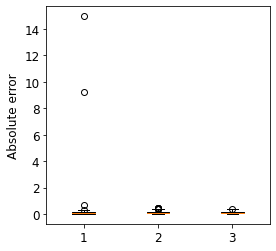

In [26]:
plt.figure(figsize=(4, 4))
plt.boxplot([errors, errors2, errors3], showbox=True)

plt.xticks(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Absolute error", fontsize=12);
# plt.savefig("coef_1_4.png", bbox_inches='tight');

In [6]:
errors2 = train_test_model(model_name = "RBF_SVR", 
                 coefficient = 2, 
                 data_set = "Dataset 4",
                X_columns = X_features,
                 drug_list = drug_ids_50, 
                 train_df = train_df_50, 
                 test_df = test_df_50,
                 folder_name = _FOLDER,
                 print_drug_names = False)


Results for coefficient 2 and model RBF_SVR

MAE: 0.231 +/- 1.585
MRE: 7.1 +/- 16.8



In [9]:
errors3 = train_test_model(model_name = "Linear_SVR", 
                 coefficient = 3, 
                 data_set = "Dataset 4",
                X_columns = X_features, 
                drug_list = drug_ids_50, 
                 train_df = train_df_50, 
                 test_df = test_df_50,
                 folder_name = _FOLDER,
                 print_drug_names = False)


Results for coefficient 3 and model Linear_SVR

MAE: 8.529 +/- 21.913
MRE: -40.5 +/- 55.3



In [10]:
errors4 = train_test_model(model_name = "RBF_KR", 
                 coefficient = 4, 
                 data_set = "Dataset 4",
                X_columns = X_features, 
                drug_list = drug_ids_50, 
                 train_df = train_df_50, 
                 test_df = test_df_50,
                 folder_name = _FOLDER,
                 print_drug_names = False)


Results for coefficient 4 and model RBF_KR

MAE: 0.069 +/- 0.087
MRE: -154.0 +/- 3177.3



### Analysis of MAE on drug-by-drug basis

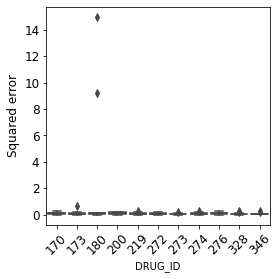

In [4]:
plt.figure(figsize=(4, 4))
sns.boxplot(x = "DRUG_ID", y = "abs_error", data = results.reset_index())

plt.xticks(rotation = 45, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Squared error", fontsize=12);

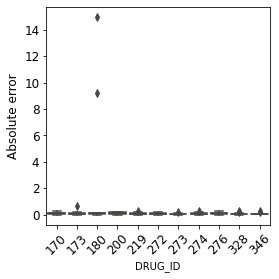

In [5]:
plt.figure(figsize=(4, 4))
sns.boxplot(x = "DRUG_ID", y = "abs_error", data = results.reset_index())

plt.xticks(rotation = 45, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Absolute error", fontsize=12)
plt.savefig("coef_1.png", bbox_inches='tight');

In [6]:
test_df_50[test_df_50["abs_error"]>8][["COSMIC_ID", "param_1", "pred_y"]]

,COSMIC_ID,param_1,pred_y
DRUG_ID,,,
180,907064,9.576391,0.348604
180,905936,15.312320,0.348623


In [7]:
test_df_50[test_df_50["COSMIC_ID"]==687777][["COSMIC_ID", "param_1", "pred_y"]]

,COSMIC_ID,param_1,pred_y
DRUG_ID,,,
173,687777,1.29139,0.623563


In [ ]:
del train_df_50
del test_df_50

### Restriction on coefficient value

Restriction on coefficient value


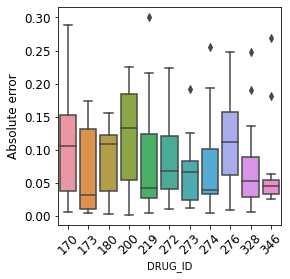

In [8]:
print("Restriction on coefficient value")
plt.figure(figsize=(4, 4))
sns.boxplot(x = "DRUG_ID", y = "abs_error", data = results[results["y"]<=1].reset_index())

plt.xticks(rotation = 45, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Absolute error", fontsize=12)
plt.savefig("coef_1_2.png", bbox_inches='tight');

### Restriction by R2

In [9]:
from sklearn.metrics import r2_score

def sigmoid_4_param(x, x0, L, k, d):
    """ Comparing with Dennis Wang's sigmoid:
    x0 -  p - position, correlation with IC50 or EC50
        bounds [0, 1]
    L = 1 in Dennis Wang's sigmoid, protect from devision by zero if x is too small 
        L<1 inverted sigmoid, l=100 - lower upper and lower boundso sigmpoid on y axis (y= [0.1, 0.11])
        bounds [0.8, 10]
    k = -1/s (s -shape parameter)  default = -10 k=0 straight line, k<0 sigmoid around k=-10
        bounds [1, -100]
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then Dennis Wang's sigmoid
         bounds [0, 0.9]
    parameters_bound ((0, 0.8, -100, 0), (1, 10, 1, 0.9))
    """
    return ( 1/ (L + np.exp(-k*(x-x0))) + d)

def r2_score_sigmoid_4_param(df, x_columns, y_columns, param_columns = []):
    r2_scores=np.zeros(len(df.index))
    for i in range(len(df.index)):
        x = df.loc[df.index[i], x_columns].values.astype(np.float32)
        y = df.loc[df.index[i], y_columns].values.astype(np.float32)
        fit_param = df.loc[df.index[i], param_columns].values.astype(np.float32)
#         print(fit_param)
        y_fit = sigmoid_4_param(x, *fit_param)
        r2_scores[i] = r2_score(y, y_fit)
    return r2_scores

test_df_50["r2_scores"] = r2_score_sigmoid_4_param(test_df_50.reset_index(), 
                                                   x_columns = ["fd_num_"+str(i) for i in range(10)],
                                                  y_columns = ["norm_cells_" + str(i) for i in range(10)],
                                                  param_columns = ["param_" + str(i) for i in range(1,5)])

print("Restriction by R2")
plt.figure(figsize=(4, 4))
sns.boxplot(x = "DRUG_ID", y = "abs_error", data = test_df_50[test_df_50["r2_scores"]>0.9].reset_index())

plt.xticks(rotation = 45, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Absolute error", fontsize=12)
plt.savefig("coef_1_3.png", bbox_inches='tight');

del train_df_50
del test_df_50

## Retraining the model on the new data: Restriction for Coefficient

In [12]:
with open(_FOLDER + "drug_ids_50.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]

train_df = pd.read_csv(_FOLDER+"train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER+"test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

train_df_50 = train_df_50[train_df_50["param_1"]<1].copy()
test_df_50 = test_df_50[test_df_50["param_1"]<1].copy()

results = pd.DataFrame()
results["y"] = test_df_50["param_1"]
results["pred_y"] = 0

for drug_id in drug_ids_50:
    drug_name = train_df_50.loc[drug_id, "Drug_Name"].values[0]
    print(drug_id, drug_name)
    train_drug = train_df_50.loc[drug_id,:]
    test_drug = test_df_50.loc[drug_id,:]
    y_train_drug = train_drug["param_1"].values
    y_test_drug =  test_drug["param_1"].values
    
    X_columns = X_feat_dict[data_set]
    scaler = MinMaxScaler().fit(train_drug[X_columns])
    Xtrain_drug = scaler.transform(train_drug[X_columns])
        
    model = KernelRidge(kernel = kernel, 
                        alpha = hyperparameters.loc[drug_id, "best_alpha3"], 
                        gamma = hyperparameters.loc[drug_id, "best_gamma3"],
                        coef0= hyperparameters.loc[drug_id, "best_coef03"], 
                        degree = hyperparameters.loc[drug_id, "best_degree3"])
        
    model.fit(Xtrain_drug, y_train_drug)
    Xtest_drug = scaler.transform(test_drug[X_columns])
        
    y_pred = model.predict(Xtest_drug)
    results.loc[drug_id, "pred_y"]= y_pred

results["abs_error"] = abs(results["y"] - results["pred_y"])
results["rel_error"] = abs(results["y"] - results["pred_y"])*100/results["y"] 
abs_errors_2 = abs(results["y"] - results["pred_y"])

print("\nMRE:", round(results["rel_error"].mean(), 1), "+/-", round(results["rel_error"].std(), 1))
print("\nMAE:", round(results["abs_error"].mean(), 3), "+/-", round(results["abs_error"].std(), 3))
print("")
print(train_df_50.shape, test_df_50.shape)

del train_df_50
del test_df_50

170 Shikonin
173 FH535
180 Thapsigargin
200 Dacinostat
219 AT-7519
272 AR-42
273 CUDC-101
274 Belinostat
276 CAY10603
328 SNX-2112
346 THZ-2-102-1

MRE: 28.0 +/- 20.1

MAE: 0.129 +/- 0.097

(765, 1379) (199, 1379)


## Retraining the model on the new data: Restriction for R2

In [15]:
with open("results/drug_ids_50_restr.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]
    

train_df = pd.read_csv("results/train08_min10_restr.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv("results/test02_min10_restr.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

results = pd.DataFrame()
results["y"] = test_df_50["param_1"]
results["pred_y"] = 0

for drug_id in drug_ids_50:
    drug_name = train_df_50.loc[drug_id, "Drug_Name"].values[0]
    print(drug_id, drug_name)
    train_drug = train_df_50.loc[drug_id,:]
    test_drug = test_df_50.loc[drug_id,:]
    y_train_drug = train_drug["param_1"].values
    y_test_drug =  test_drug["param_1"].values
    
    X_columns = X_feat_dict[data_set]
    scaler = MinMaxScaler().fit(train_drug[X_columns])
    Xtrain_drug = scaler.transform(train_drug[X_columns])
        
    model = KernelRidge(kernel = kernel, 
                        alpha = hyperparameters.loc[drug_id, "best_alpha3"], 
                        gamma = hyperparameters.loc[drug_id, "best_gamma3"],
                        coef0= hyperparameters.loc[drug_id, "best_coef03"], 
                        degree = hyperparameters.loc[drug_id, "best_degree3"])
        
    model.fit(Xtrain_drug, y_train_drug)
    Xtest_drug = scaler.transform(test_drug[X_columns])
        
    y_pred = model.predict(Xtest_drug)
    results.loc[drug_id, "pred_y"]= y_pred

results["abs_error"] = abs(results["y"] - results["pred_y"])
results["rel_error"] = abs(results["y"] - results["pred_y"])*100/results["y"]
abs_errors_3 = abs(results["y"] - results["pred_y"])

print("\nMRE:", round(results["rel_error"].mean(), 1), "+/-", round(results["rel_error"].std(), 1))
print("\nMAE:", round(results["abs_error"].mean(), 3), "+/-", round(results["abs_error"].std(), 3))
print("")
print(train_df_50.shape, test_df_50.shape)
del train_df_50
del test_df_50

170 Shikonin
180 Thapsigargin
200 Dacinostat
219 AT-7519
272 AR-42
273 CUDC-101
274 Belinostat
276 CAY10603
328 SNX-2112
346 THZ-2-102-1

MRE: 27.8 +/- 19.2

MAE: 0.122 +/- 0.084

(723, 1380) (185, 1380)


Restriction by R2


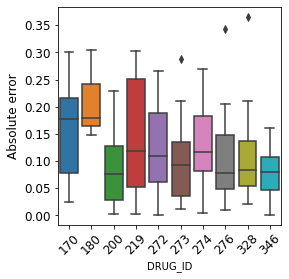

In [17]:
print("Restriction by R2")
plt.figure(figsize=(4, 4))
sns.boxplot(x = "DRUG_ID", y = "abs_error", data = results.reset_index())

plt.xticks(rotation = 45, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Absolute error", fontsize=12)
plt.savefig("coef_1_4.png", bbox_inches='tight');

### Feature importance

RFE feature selection is possible only for the linear kernel!!!
<br>Therefore we need to read the data with the best hyperparameters for linear model
The best variant seems to be SVR Linear

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

df = pd.read_csv(_FOLDER+ "Linear_SVR_coef1.csv").rename(columns={"Unnamed: 0": "DRUG_ID"})

hyperparameters_rfe = df[['DRUG_ID', 'best_C3', 'best_epsilon3']].set_index("DRUG_ID")
# best.to_csv(_FOLDER+"best_model_coef_" +str(i)+ ".csv")
hyperparameters_rfe

In [ ]:
# testing of the approach

drug_id =170
    
train_drug = train_df_50.loc[drug_id,:]
test_drug = test_df_50.loc[drug_id,:]
y_train_drug = train_drug["param_1"].values
y_test_drug =  test_drug["param_1"].values
    
X_columns = X_feat_dict[data_set]
scaler = MinMaxScaler().fit(train_drug[X_columns])
Xtrain_drug = scaler.transform(train_drug[X_columns])
estimator = SVR(kernel = "linear", 
                    C = hyperparameters_rfe.loc[drug_id, 'best_C3'],
                    epsilon = hyperparameters_rfe.loc[drug_id,'best_epsilon3'])
estimator.fit(Xtrain_drug, y_train_drug)
sum(abs(estimator.coef_[0])>0.01)

## RFE on original data

In [ ]:
with open(_FOLDER + "drug_ids_50.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]


all_columns = X_cancer_cell_lines + X_PubChem_properties + X_targets + X_target_pathway +["MAX_CONC"]

train_df = pd.read_csv(_FOLDER+"train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER+"test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

df_features = pd.DataFrame(index=drug_ids_50)
most_important = {}

for drug_id in drug_ids_50:
    drug_name = train_df_50.loc[drug_id, "Drug_Name"].values[0]
    
    train_drug = train_df_50.loc[drug_id,:]
    test_drug = test_df_50.loc[drug_id,:]
    y_train_drug = train_drug["param_1"].values
    y_test_drug =  test_drug["param_1"].values
    
    X_columns = X_feat_dict[data_set]
    scaler = MinMaxScaler().fit(train_drug[X_columns])
    Xtrain_drug = scaler.transform(train_drug[X_columns])
        
    estimator = SVR(kernel = "linear", 
                    C = hyperparameters_rfe.loc[drug_id, 'best_C3'],
                    epsilon = hyperparameters_rfe.loc[drug_id,'best_epsilon3'])
    estimator.fit(Xtrain_drug, y_train_drug)
    
    most_important[drug_id] = np.array(X_columns)[selector.support_]
    df_features.loc[drug_id, "zero"] = len(estimator.coef_[estimator.coef_==0])
    df_features.loc[drug_id, "max"] = round(abs(estimator.coef_[0]).max(),3)
    df_features.loc[drug_id, "more_0_01"] =sum(abs(estimator.coef_[0])>0.01)
    
df_features["zero"] = df_features["zero"].astype('int32')
df_features["more_0_01"] = df_features["more_0_01"].astype('int32')
df_features

In [ ]:
pd.DataFrame(data= [int(df_features["zero"].mean()), df_features["max"].max(), int(df_features["more_0_01"].mean())]).T

In [ ]:
all_features = []
for key in most_important.keys():
    all_features.extend(most_important[key])
most_important_features = set(all_features)
len(all_features), len(most_important_features)

df_features = pd.DataFrame(index = list(most_important_features), columns = drug_ids_50)
for drug_id in drug_ids_50:
    df_features[drug_id] = 0
    df_features.loc[most_important[drug_id], drug_id]=1

df_features["sum"]= df_features[drug_ids_50].sum(axis=1)
df_features.sort_values("sum", ascending = False)

from_CCLE = set(most_important_features)& set(X_cancer_cell_lines)
print("from CCL:", len(set(most_important_features)& set(X_cancer_cell_lines)))
print("from PubChem_properties",len( set(most_important_features)& set(X_PubChem_properties)))
print("from targets:", len(set(most_important_features)& set(X_targets)))
print("from target pathway:", len(set(most_important_features)& set(X_target_pathway)))

## RFE on reduced by R2 data

In [ ]:
with open("results/drug_ids_50_restr.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]

# reduced by R2 filtration criteria    
train_df = pd.read_csv("results/train08_min10_restr.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv("results/test02_min10_restr.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

df_features_2 = pd.DataFrame(index=drug_ids_50)
most_important_2 = {}
for drug_id in drug_ids_50:
    drug_name = train_df_50.loc[drug_id, "Drug_Name"].values[0]
    
    train_drug = train_df_50.loc[drug_id,:]
    test_drug = test_df_50.loc[drug_id,:]
    y_train_drug = train_drug["param_1"].values
    y_test_drug =  test_drug["param_1"].values
    
    X_columns = X_feat_dict[data_set]
#     print(drug_id, drug_name, len(X_columns))
    scaler = MinMaxScaler().fit(train_drug[X_columns])
    Xtrain_drug = scaler.transform(train_drug[X_columns])
        
    estimator = SVR(kernel = "linear", 
                    C = hyperparameters_rfe.loc[drug_id, 'best_C3'],
                    epsilon = hyperparameters_rfe.loc[drug_id,'best_epsilon3'])
    estimator.fit(Xtrain_drug, y_train_drug)
    df_features_2.loc[drug_id, "zero"] = len(estimator.coef_[estimator.coef_==0])
    df_features_2.loc[drug_id, "max"] = round(abs(estimator.coef_[0]).max(),3)
    df_features_2.loc[drug_id, "more_0_01"] =sum(abs(estimator.coef_[0])>0.01)

del train_df_50
del test_df_50

df_features_2["zero"] = df_features_2["zero"].astype('int32')
df_features_2["more_0_01"] = df_features_2["more_0_01"].astype('int32')
df_features_2

In [ ]:
pd.DataFrame(data= [int(df_features_2["zero"].mean()), df_features_2["max"].max(), int(df_features_2["more_0_01"].mean())]).T

## Train on reduced data: Restriction for R2 and top50 features subset 

In [ ]:
with open("results/drug_ids_50_restr.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]

# reduced by R2 filtration criteria    
train_df = pd.read_csv("results/train08_min10_restr.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv("results/test02_min10_restr.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()


results = pd.DataFrame()
results["y"] = test_df_50["param_1"]
results["pred_y"] = 0

for drug_id in drug_ids_50:
    drug_name = train_df_50.loc[drug_id, "Drug_Name"].values[0]
    print(drug_id, drug_name)
    train_drug = train_df_50.loc[drug_id,:]
    test_drug = test_df_50.loc[drug_id,:]
    y_train_drug = train_drug["param_1"].values
    y_test_drug =  test_drug["param_1"].values
    
    #features subset
    X_columns = most_important[drug_id]
    scaler = MinMaxScaler().fit(train_drug[X_columns])
    Xtrain_drug = scaler.transform(train_drug[X_columns])
        
    model = KernelRidge(kernel = kernel, 
                        alpha = hyperparameters.loc[drug_id, "best_alpha3"], 
                        gamma = hyperparameters.loc[drug_id, "best_gamma3"],
                        coef0= hyperparameters.loc[drug_id, "best_coef03"], 
                        degree = hyperparameters.loc[drug_id, "best_degree3"])
        
    model.fit(Xtrain_drug, y_train_drug)
    Xtest_drug = scaler.transform(test_drug[X_columns])
        
    y_pred = model.predict(Xtest_drug)
    results.loc[drug_id, "pred_y"]= y_pred

results["abs_error"] = abs(results["y"] - results["pred_y"])
results["rel_error"] = abs(results["y"] - results["pred_y"])*100/results["y"]
abs_errors_4 = abs(results["y"] - results["pred_y"])

print("\nMRE:", round(results["rel_error"].mean(), 1), "+/-", round(results["rel_error"].std(), 1))
print("\nMAE:", round(results["abs_error"].mean(), 3), "+/-", round(results["abs_error"].std(), 3))
print("")
print(train_df_50.shape, test_df_50.shape)
del train_df_50
del test_df_50

## Training on original data and feature subset

In [ ]:
with open(_FOLDER + "drug_ids_50.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]


all_columns = X_cancer_cell_lines + X_PubChem_properties + X_targets + X_target_pathway +["MAX_CONC"]

train_df = pd.read_csv(_FOLDER+"train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER+"test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()


results = pd.DataFrame()
results["y"] = test_df_50["param_1"]
results["pred_y"] = 0

for drug_id in drug_ids_50:
    drug_name = train_df_50.loc[drug_id, "Drug_Name"].values[0]
    print(drug_id, drug_name)
    train_drug = train_df_50.loc[drug_id,:]
    test_drug = test_df_50.loc[drug_id,:]
    y_train_drug = train_drug["param_1"].values
    y_test_drug =  test_drug["param_1"].values
    
    #features subset
    X_columns = most_important[drug_id]
    
    scaler = MinMaxScaler().fit(train_drug[X_columns])
    Xtrain_drug = scaler.transform(train_drug[X_columns])
        
    model = KernelRidge(kernel = kernel, 
                        alpha = hyperparameters.loc[drug_id, "best_alpha3"], 
                        gamma = hyperparameters.loc[drug_id, "best_gamma3"],
                        coef0= hyperparameters.loc[drug_id, "best_coef03"], 
                        degree = hyperparameters.loc[drug_id, "best_degree3"])
        
    model.fit(Xtrain_drug, y_train_drug)
    Xtest_drug = scaler.transform(test_drug[X_columns])
        
    y_pred = model.predict(Xtest_drug)
    results.loc[drug_id, "pred_y"]= y_pred

results["abs_error"] = abs(results["y"] - results["pred_y"])
results["rel_error"] = abs(results["y"] - results["pred_y"])*100/results["y"] 

print("MAE:", round(results["abs_error"].mean(), 3), "+/-", round(results["abs_error"].std(), 3))
print("MRE:", round(results["rel_error"].mean(), 1), "+/-", round(results["rel_error"].std(), 1))

### Training on the subset of top50 features and reduced data

In [ ]:
with open(_FOLDER + "drug_ids_50.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]

train_df = pd.read_csv(_FOLDER+"train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER+"test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()


results = pd.DataFrame()
results["y"] = test_df_50["param_1"]
results["pred_y"] = 0

for drug_id in drug_ids_50:
    drug_name = train_df_50.loc[drug_id, "Drug_Name"].values[0]
    print(drug_id, drug_name)
    train_drug = train_df_50.loc[drug_id,:]
    test_drug = test_df_50.loc[drug_id,:]
    y_train_drug = train_drug["param_1"].values
    y_test_drug =  test_drug["param_1"].values
    
    X_columns = most_important[drug_id]
    scaler = MinMaxScaler().fit(train_drug[X_columns])
    Xtrain_drug = scaler.transform(train_drug[X_columns])
        
    model = KernelRidge(kernel = kernel, 
                        alpha = hyperparameters.loc[drug_id, "best_alpha3"], 
                        gamma = hyperparameters.loc[drug_id, "best_gamma3"],
                        coef0= hyperparameters.loc[drug_id, "best_coef03"], 
                        degree = hyperparameters.loc[drug_id, "best_degree3"])
        
    model.fit(Xtrain_drug, y_train_drug)
    Xtest_drug = scaler.transform(test_drug[X_columns])
        
    y_pred = model.predict(Xtest_drug)
    results.loc[drug_id, "pred_y"]= y_pred

results["abs_error"] = abs(results["y"] - results["pred_y"])
results["rel_error"] = abs(results["y"] - results["pred_y"])*100/results["y"] 

print("MAE:", round(results["abs_error"].mean(), 3), "+/-", round(results["abs_error"].std(), 3))
print("MRE:", round(results["rel_error"].mean(), 1), "+/-", round(results["rel_error"].std(), 1))